<a href="https://colab.research.google.com/github/h777arsh/PyTorch-Tutorial/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#convert MNIST image files into a Tensor of 4-Dimen
transform = transforms.ToTensor()

In [6]:
#Train Data
train_data = datasets.MNIST(root= '/cnn_data', train = True, download = True, transform = transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17728206.51it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 488389.33it/s]


Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1428040.75it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4528293.03it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [7]:
test_data = datasets.MNIST(root= '/cnn_data', train = False, download = True, transform = transform)

In [8]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
# create a small batch size for images...
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False)

In [11]:
# Define our CNN model
# Describe convolutional layer and what it's doing

conv1 = nn.Conv2d(1, 6 , 3, 1)
conv2 = nn.Conv2d(6, 16 , 3, 1)

In [12]:
# Grab 1 MNIST Record/Image

for i, (X_Train, y_train) in enumerate(train_data):
  break


In [13]:
X_Train.shape

torch.Size([1, 28, 28])

In [14]:
x = X_Train.view(1, 1, 28, 28) # making 4d

In [15]:
# Perform our first convolutional
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function

In [16]:
x.shape

torch.Size([1, 6, 26, 26])

In [17]:
# pass thru the pooling layer
x = F.max_pool2d(x, 2, 2) # kernal size = 2 , stride = 2

In [18]:
x.shape

torch.Size([1, 6, 13, 13])

In [19]:
# Do our second convolutional layer

x = F.relu(conv2(x))

In [21]:
x.shape # we didn't set the padding that's why we are loosing outside pixels

torch.Size([1, 16, 11, 11])

In [22]:
x = F.max_pool2d(x, 2, 2)

In [24]:
x.shape # 11/2 as we have round down, because you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [25]:
# Model Class

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # fully connected Layer
    self.fc1 = nn.Linear(5 * 5 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # kernel = 2, stride = 2
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    # Re-View to flattern it out
    X = X.view(-1, 16 * 5 * 5) # negative one so that we can vary the batch size

    # Fully connected layer
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X) # don't need to do relu because it's a last one

    return F.log_softmax(X, dim = 1)

In [27]:
torch.manual_seed(41) # just to get the same number, no need in prod
model = ConvolutionalNetwork()
model


ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [29]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Smaller the learning rate longer its gonna take to train

In [30]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  train_corr = 0
  test_corr = 0

  for b, (X_train, y_train) in enumerate(train_loader):
    b+= 1
    y_pred = model(X_train) # get predicted values from the training set. Not Flattened it's in 2d
    loss = criterion(y_pred, y_train) # how off are we? compare the prediction with correct answer in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch.
    train_corr += batch_corr # keep track as we go along in the training.

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)

  # Test

  with torch.no_grad():
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # adding up correct predictions
      test_corr += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)



current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} m')

Epoch: 0 Batch: 600 Loss: 0.1599934995174408
Epoch: 0 Batch: 1200 Loss: 0.18979528546333313
Epoch: 0 Batch: 1800 Loss: 0.5580862760543823
Epoch: 0 Batch: 2400 Loss: 0.2070152312517166
Epoch: 0 Batch: 3000 Loss: 0.006888664327561855
Epoch: 0 Batch: 3600 Loss: 0.33112621307373047
Epoch: 0 Batch: 4200 Loss: 0.004664934705942869
Epoch: 0 Batch: 4800 Loss: 0.0020317500457167625
Epoch: 0 Batch: 5400 Loss: 0.06558699160814285
Epoch: 0 Batch: 6000 Loss: 0.000513441045768559
Epoch: 1 Batch: 600 Loss: 0.004773168824613094
Epoch: 1 Batch: 1200 Loss: 0.30684694647789
Epoch: 1 Batch: 1800 Loss: 0.0025840331800282
Epoch: 1 Batch: 2400 Loss: 0.004851708188652992
Epoch: 1 Batch: 3000 Loss: 0.05095291882753372
Epoch: 1 Batch: 3600 Loss: 0.29904529452323914
Epoch: 1 Batch: 4200 Loss: 0.020275484770536423
Epoch: 1 Batch: 4800 Loss: 0.0018002415308728814
Epoch: 1 Batch: 5400 Loss: 0.0003511425748001784
Epoch: 1 Batch: 6000 Loss: 0.16817066073417664
Epoch: 2 Batch: 600 Loss: 0.044435493648052216
Epoch: 2 B

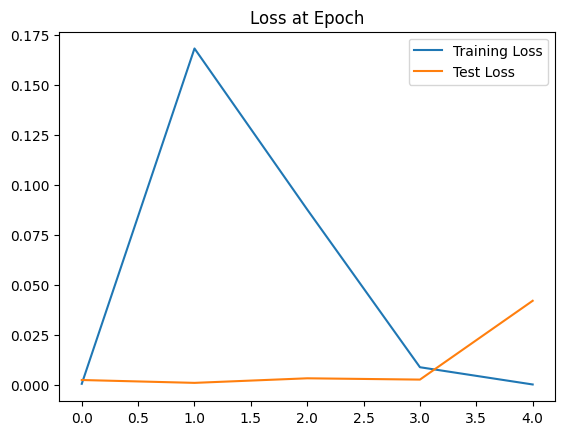

In [31]:
train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Test Loss")
plt.title("Loss at Epoch")
plt.legend()

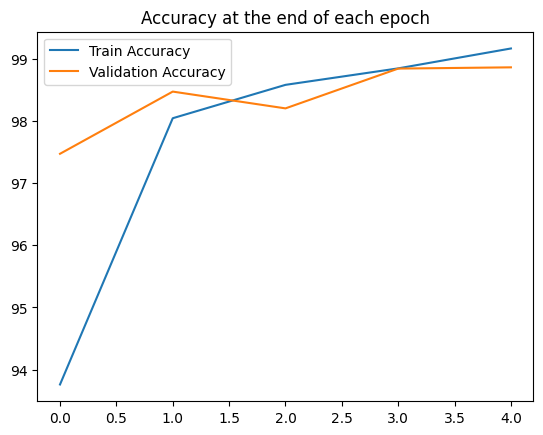

In [33]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = "Train Accuracy")
plt.plot([t/100 for t in test_correct], label = "Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [35]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle = False)

In [36]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [37]:
correct.item()

9886

In [38]:
correct.item() / len(test_data)

0.9886

In [39]:
# Grab an image
test_data[4143] # tesnor with an image in it

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [40]:
#reshape
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

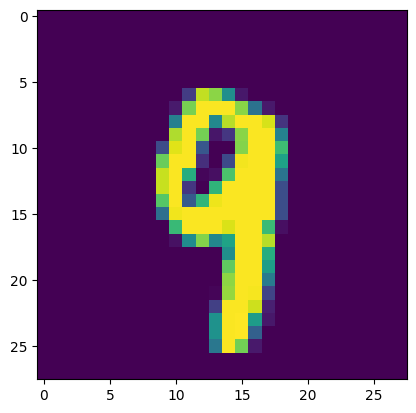

In [41]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [45]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[5143][0].view(1,1,28,28))

In [46]:
new_prediction

tensor([[-2.5061e+01, -1.6966e+01, -1.5351e+01, -3.5763e-07, -2.9872e+01,
         -1.6592e+01, -2.7485e+01, -1.7794e+01, -1.8740e+01, -2.0993e+01]])

In [47]:
new_prediction.argmax()

tensor(3)